In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit
!pip install mordred
!pip install shap
!pip install botorch
!pip install git+https://github.com/samoturk/mol2vec
!pip install rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 373 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 4.4 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=679536c23287ef02d6c2864cce116612a8f82a4eb04b173ef4cb995e0a9d43dd
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 4.1 MB/s 
     |████████████████████████████████| 722 kB 41.7 MB/s 
     |████████████████████████

In [ ]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from tqdm import tqdm

# Load Data

In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/Material Informatics/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df_Cbg = df_Cbg.dropna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


# Mol2Vec descriptor

In [ ]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./drive/MyDrive/Material Informatics/Conductive polymer QSAR/model_300dim.pkl')#Check structure of each module

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
Molecular_sentence = mol2sentence(df_Cbg['Mols'][0] , radius=2)
Molecular_sentence_alt = mol2alt_sentence(df_Cbg['Mols'][0] , radius=2)
MolSentence_object = MolSentence(mol2alt_sentence(df_Cbg['Mols'][0] , radius=2))
DfVec_object = DfVec(sentences2vec(mol2alt_sentence(df_Cbg['Mols'][0] , radius=2), model, unseen='UNK'))

In [ ]:
# Build a mol2vec module
def mol2vec(mols, radius=2):
    from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
    
    #Loading pre-trained model via word2vec
    from gensim.models import word2vec
    model = word2vec.Word2Vec.load('./drive/MyDrive/Material Informatics/Conductive polymer QSAR/model_300dim.pkl')
    sentences =[]
    for idx, mol in enumerate(tqdm(mols)):
      sentences.append(MolSentence(mol2alt_sentence(mol, radius)))
    return pd.DataFrame(sentences2vec(sentences, model, unseen='UNK'))

In [ ]:
#Build vector from mol file.
vec = mol2vec(df_Cbg['Mols'])
vec.shape

100%|██████████| 284/284 [00:00<00:00, 2186.70it/s]


(284, 300)

In [ ]:
vec.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.704333,2.825328,-1.319941,2.845881,-1.759477,-1.744895,-6.925913,1.144386,3.776510,3.364295,...,0.580129,1.658787,1.737977,1.708964,0.151297,1.085893,-2.961081,-4.840187,-3.024478,1.719892
1,1.602170,3.411885,-3.034436,7.674419,-3.318744,-2.135357,-11.067231,2.828823,5.584457,5.340602,...,-0.339466,4.548288,3.307216,2.781326,-0.209363,0.940120,-3.997675,-5.333462,-5.109267,2.521786
2,3.411203,4.674567,-6.083987,14.208692,-6.468419,-3.220790,-18.692713,5.160111,9.839040,10.001861,...,-0.478767,10.741097,7.045157,2.764154,-1.308130,0.441552,-8.190417,-8.344453,-10.266222,5.263697
3,0.778925,3.557336,-3.079961,5.381880,-3.154149,-2.356366,-9.198513,2.806979,5.796416,5.689905,...,1.774877,5.373628,1.875300,1.800868,-0.674957,-0.389359,-5.177107,-5.595406,-5.604986,2.740444
4,2.050051,4.612771,-4.355314,9.977927,-4.918985,-2.472611,-13.770000,3.894274,7.570386,7.841415,...,1.188504,7.572122,3.621387,2.373468,-1.248150,0.169250,-6.543545,-6.340064,-7.373953,4.126472


# Gaussian Process Model fitting

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
rmse_list = []
y_test_group = []
y_pred_group = []

X = vec.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  from sklearn.preprocessing import MinMaxScaler,StandardScaler

  # X must be in the range=(0, 1)
  # use MinMaxScaler to transform features
  mmscaler = MinMaxScaler()
  X_train_mm = mmscaler.fit_transform(X_train)
  X_test_mm = mmscaler.transform(X_test)

  X_train_tensor = torch.from_numpy(np.array(X_train_mm))
  X_test_tensor = torch.from_numpy(np.array(X_test_mm))


  # Y must be in the range=(-1, 1)
  y_scaler = StandardScaler()
  y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
  y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

  y_train_tensor = torch.from_numpy(np.array(y_train_s))
  y_test_tensor = torch.from_numpy(np.array(y_test_s))
  
  #Model fitting
  kernel = RBFKernel(ard_num_dims=X.shape[1])
  gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
  mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
  fit_gpytorch_model(mll)

  #Prediction
  y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
  y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()
  
  y_test_group.append(y_test_s[0])#r2は2D 以下のarrayが必要なため、1Darrayを抽出しgroupに入れて、2Dにする。
  y_pred_group.append(y_test_pred[0])
  
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average R square is {avg_rsquare}')

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
63it [03:29,  2.85s/it]/usr/local/lib/python3.7/dist-packages/botorch/fit.py:148: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(w.message, w.category)
/usr/local/lib/python3.7/dist-packages/botorch/fit.py:148: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(w.message, w.category)
/usr/local/lib/python3.7/dist-packages/botorch/fit.py:

Average R square is 0.8874996866885042


# Feature Selection

##Filter Method

Low Variance Filter

In [ ]:
from copy import copy

thresheld = 0.1  #10%

data = copy(vec) #only check X variables
var = data.var()
X_col = data.columns
variable = X_col[var >=thresheld] #find columns to keep
data = data[variable]

print (data.shape)

(284, 299)


High Correlation Filter

In [ ]:
#Filter Method is the first step to perform when selecting features.
from copy import copy

thresheld = 0.8

# data = copy(vec) #Stacking with low variance filter
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #using 'where' and input array to choose a specific cell in dataframe
to_drop = [column for column in upper.columns if any(upper[column] >= thresheld)] #find columns to drop
data = data.drop(columns = to_drop) 

print (data.shape)

(284, 73)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


## Wrapper Method

Exhaustive Feature Selector (Neglect due to long computation time)

In [ ]:
# #Import mlxtend
# !pip install mlxtend

# #Fix the bug of joblib
# import joblib
# import sys
# sys.modules['sklearn.externals.joblib'] = joblib

# #Applying EFS
# import lightgbm as lgb
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# model = lgb.LGBMRegressor(random_state=6174)
# efs1 = EFS(model, 
#            min_features=1,
#            max_features=4,
#            scoring='r2',
#            print_progress=True,
#            cv=2)

# efs1 = efs1.fit(X, y)

# print('Best accuracy score: %.2f' % efs1.best_score_)
# print('Best subset (indices):', efs1.best_idx_)
# print('Best subset (corresponding names):', efs1.best_feature_names_)

Forward Selection

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime as dt

sum = {}

from sklearn.feature_selection import SequentialFeatureSelector
import lightgbm as lgb
X = data.values
y = df_Cbg.iloc[:, -3].values

# Sequential Feature Selection
forward_lgb = lgb.LGBMRegressor(random_state=6174)

for i in [5, 50]:
  start = dt.now()
  # forward selection
  sfs = SequentialFeatureSelector(forward_lgb, n_features_to_select=i,
                                  scoring="neg_mean_squared_error",
                                  direction="forward", n_jobs=12)
  sfs.fit(X, y)

  # 選択した特徴量を用いてモデルを学習する
  forward_idx = sfs.get_support(indices=False)

  #New accuracy with selected features
  X_new = pd.DataFrame(sfs.transform(X), columns=data.columns.values[forward_idx])
  X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

  model=RandomForestRegressor(random_state=0)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  new_r2 = r2_score(y_pred, y_test)
  print(new_r2)
  sum[f'{i}'] = new_r2
  running_secs = (dt.now() - start).seconds
  print(running_secs)

0.7060801201868705
38
0.8042545461399306
463


In [ ]:
print(pd.DataFrame(sum, index=['r2']))

          5        50
r2  0.70608  0.804255


## Embedded Method

Oridignal Rsquare

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

model=RandomForestRegressor(random_state=0)

# #Preparing train, test data
X = data.values
y = df_Cbg.iloc[:, -3].values

# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ori_r2 = r2_score(y_pred, y_test)
print(ori_r2)

0.8085243019572047


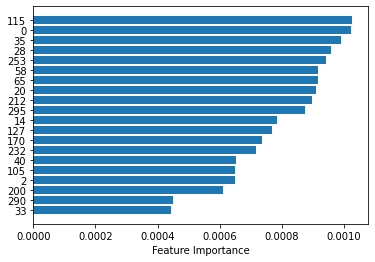

In [ ]:
import matplotlib.pyplot as plt

#Plot 20 least important features
sort = model.feature_importances_.argsort()
plt.barh(data.columns[sort].astype(str)[:20], model.feature_importances_[sort][:20])
plt.xlabel("Feature Importance")
plt.show()

Rsquare (features dropped)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#Dropping least important 20 features
new_data= data.drop(data.columns[sort][:20], axis=1)

model=RandomForestRegressor(random_state=0)

#Preparing train, test data
X = new_data.values
y = df_Cbg.iloc[:, -3].values

# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
new_r2 = r2_score(y_pred, y_test)
print(ori_r2)
print(new_r2)

0.8085243019572047
0.7971423419224599
